In [1]:
# https://stepik.org/course/68260/syllabus

## Содержание  
[3.1 Метод ближайших соседей (классификация)](#3.1)  
[3.1.1 Инициализация класса](#3.1.1)  
[3.1.2 Обучение](#3.1.2)  
[3.1.3 Предсказание](#3.1.3)  
[3.1.4 Метрики](#3.1.4)  
[3.1.5 Взвешенный kNN](#3.1.5)  
  
[3.2 Метод ближайших соседей (регрессия)](#3.2)   
[3.2.1 Инициализация класса](#3.2.1)  
[3.2.2 Обучение](#3.2.2)  
[3.2.3 Предсказание](#3.2.3)  
[3.2.4 Метрики](#3.2.4)  
[3.2.5 Взвешенный kNN](#3.2.5)  

[Финальные версии моделей](#3fin)

## 3.1 Метод ближайших соседей (классификация)<a id='3.1'></a>


In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=50, n_features=5, n_informative=2, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)
X.columns = [f'col_{col}' for col in X.columns]

Метод ближайших соседей (k Nearest Neighbors, или kNN) — простой алгоритм классификации (регрессии), основанный на оценивании сходства объектов. Суть метода проста: объект относится к тому классу, к которому принадлежит большинство из его ближайших k соседей.  
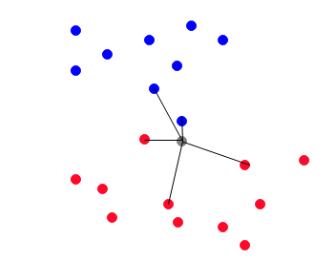   

Одно из интересных свойств данного алгоритма: в процессе обучения по сути никакого обучения не происходит. Модель просто запоминает обучающий набор. Основная работа происходит в момент классификации тестового набора: вычисляются расстояния между всеми тестовыми точками и всеми точками из обучающего набора. А затем для каждой тестовой точки отбираются ближайшие соседи и происходит классификация.  
 
Существует достаточно много метрик, с помощью которых вычисляются расстояния до ближайших точек:  

* Евклидово расстояние (обычно используется по умолчанию);  
* Метрика Хэмминга;  
* Косинусное расстояние (косинусное сходство);  
* Расстояние Минковского;  
* И пр.  

На практике, для ускорения работы часто пользуются приближенными методами поиска ближайших соседей.  

Плюсы метода ближайших соседей:  

* Простая реализация;  
* Неплохая интерпретация: можно объяснить, почему тестовый пример был классифицирован именно так.  

Минусы:  

* Как правило метод работает медленно. Особенно на больших тренировочных наборах;  
* Неэффективный по памяти, поскольку нужно хранить в модели всю обучающую выборку;  
* Если в наборе данных много признаков, то трудно определить, какие признаки не важны для классификации (регрессии);  
* В случае малого числа соседей метод чувствителен к выбросам, т.е. склонен переобучаться.

### 3.1.1 Инициализация класса<a id='3.1.1'></a>

Создайте класс с именем MyKNNClf. Данный класс при инициализации должен принимать только один параметр:

* k – кол-во ближайших соседей, которое будем рассматривать при определении класса. По-умолчанию: 3.  

Все переданные (или дефолтные) параметры должны быть сохранены внутри экземпляра класса.  
При обращении к экземпляру класса (или при передачи его в функцию print) необходимо распечатать строку по следующему шаблону:  
```python
MyKNNClf class: k=<k>
```

In [4]:
class MyKNNClf():
    
    def __init__(self,
                 k: int = 3):
    
        self.k = k
        
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNClf class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()

In [5]:
knn = MyKNNClf()
print(knn)
knn

MyKNNClf class: k=3


MyKNNClf class: k=3

### 3.1.2 Обучение<a id='3.1.2'></a>

Доработайте класс MyKNNClf следующим образом:  

1. В инициализатор класса добавьте переменную train_size (не параметр, а именно переменную). В ней будет храниться размер обучающей выборки.  
2. Добавьте в класс метод fit. Данный метод должен делать следующее:  
    1. На вход принимать две переменные:  
        * X — все фичи в виде датафрейма пандаса.  
        * y — целевая переменная в виде пандасовской серии.  
    2. Сохранить X и y внутри модели.  
    3. Записать в переменную train_size размер тренировочной выборки (X) в виде кортежа: (количество_строк, количество_столбцов)

In [6]:
class MyKNNClf():
    
    def __init__(self,
                 k: int = 3):
    
        self.k = k
        
        self.train_size = None
        self.X_train = None
        self.y_train = None
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNClf class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)

In [7]:
knn = MyKNNClf(3)
knn.fit(X, y)

In [8]:
knn.train_size

(50, 5)

### 3.1.3 Предсказание<a id='3.1.3'></a>

Добавьте в класс MyKNNClf методы predict и predict_proba. Данные методы должны делать следующее:  

**predict**  

1. На вход принимать матрицу фичей в виде датафрейма пандаса.  
2. Для каждого объекта тестовой выборки последовательно выполнить следующие шаги:  
    1. Вычислить расстояние до каждого объекта из обучающей выборки. Сейчас расстояние будем вычислять по формуле Евклида (на следующих шагах рассмотрим и другие метрики). Для двух точек с тремя координатами (фичами) Евклидово расстояние считается так: $$D_{eucl} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}$$  
        где:  
        * x1, y1, z1 – координаты (или иные количественные свойства) первой точки;  
        * x2, y2, z2 – координаты второй точки.
        
    2. Отобрать k объектов обучающей выборки, расстояние до которых минимально.  
    3. Определить, какой класс наиболее часто встречается (мода) – это и будет классом целевого объекта. Если число объектов в каждом из классов одинаковое, возвращаем класс 1. З.Ы. Рассматриваем только задачу бинарной классификации (с классами 0 и 1).
3. Вернуть вектор предсказаний.  

**predict_proba**  

1. На вход принимать матрицу фичей в виде датафрейма пандаса.  
2. Для каждого объекта тестовой выборки последовательно выполнить следующие шаги:  
    1. Вычислить Евклидово расстояние до каждого объекта из обучающей выборки.  
    2. Отобрать k объектов обучающей выборки, расстояние до которых минимально.  
    3. Подсчитать вероятность для класса 1.      
3. Вернуть список вероятностей.

In [9]:
class MyKNNClf():
    
    def __init__(self,
                 k: int = 3):
    
        self.k = k
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNClf class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)
        
    def predict(self, X: pd.DataFrame) -> np.array:
        y_pred = np.array([])
        for i in range(X.shape[0]):
            start_point = X.iloc[i]
            distance_list = np.array([])

            for j in range(self.train_size[0]):
                end_point = self.X_train.iloc[j]
                # Вычисление расстояния до каждого объекта выборки
                d_eucl = (((end_point - start_point) ** 2).sum())**0.5
                distance_list = np.append(distance_list, d_eucl)

            # Отбираются k объектов, расстояние до которых минимально
            distance_list = np.array(distance_list)
            k_near = np.argsort(distance_list)[:self.k]
            k_near_class = self.y_train[k_near].to_numpy().ravel()  

            # Определяется мода, если число объектов в каждом из классов одинаковое, возвращается класс 1.
            values, counts = np.unique(k_near_class, return_counts=True)
            max_count_index = np.argmax(counts)
            mode_value = values[max_count_index]
            mode_count = counts[max_count_index]
            if (self.k / mode_count) == 2:
                y_pred = np.append(y_pred, 1)
            else:
                y_pred = np.append(y_pred, mode_value)
                
        return y_pred.astype(np.int64)
    
    def predict_proba(self, X: pd.DataFrame) -> np.array:
        y_pred_proba = np.array([])
        for i in range(X.shape[0]):
            start_point = X.iloc[i]
            distance_list = []

            for j in range(self.train_size[0]):
                end_point = self.X_train.iloc[j]
                # Вычисление расстояния до каждого объекта выборки
                d_eucl = np.sqrt(((end_point - start_point) ** 2).sum())
                distance_list.append(d_eucl)

            # Отбираются k объектов, расстояние до которых минимально
            distance_list = np.array(distance_list)
            k_near = np.argsort(distance_list)[:self.k]
            k_near_class = self.y_train[k_near].to_numpy().ravel() 

            # Определяется мода, если число объектов в каждом из классов одинаковое, возвращается класс 1.
            values, counts = np.unique(k_near_class, return_counts=True)
            max_count_index = np.argmax(counts)
            mode_value = values[max_count_index]
            mode_count = counts[max_count_index]

            if mode_value == 1:
                y_pred_proba = np.append(y_pred_proba, mode_count / self.k)
            else:
                y_pred_proba = np.append(y_pred_proba, (self.k - mode_count) / self.k)

        return y_pred_proba

In [10]:
knn = MyKNNClf(1)
knn.fit(X, y)

In [11]:
pred = knn.predict(X)
pred

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1], dtype=int64)

In [12]:
pred.sum()

25

In [13]:
pred_proba = knn.predict_proba(X)
pred_proba

array([1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

In [14]:
pred_proba.sum()

25.0

### 3.1.4 Метрики<a id='3.1.4'></a>

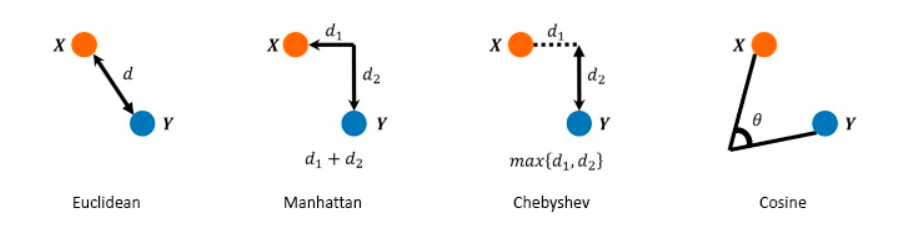  

**Евклидово расстояние**  
Евклидово расстояние в двумерном и трехмерном пространстве представляет собой прямую линию, соединяющую две точки.  

Евклидово расстояние мы уже знаем как вычисляется:  
$$\large
D_{eucl} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}
$$  
где:  
* x1, y1, z1  - координаты (или иные количественные свойства) первой точки;  
* x2, y2, z2  - координаты второй точки.  

**Манхэттенское расстояние**  
Манхэттенское расстояние измеряет дистанцию не по кратчайшей прямой, а по блокам: это расстояние всех прямых линий пути.  
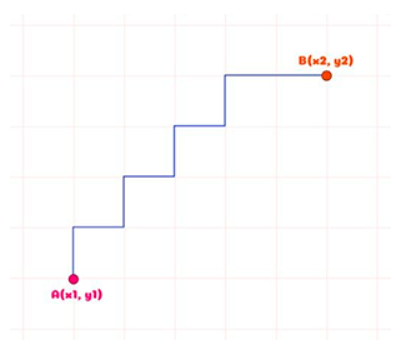  
В трехмерном пространстве Манхэттенское расстояние между двумя точками рассчитывается так:  
$$\large
D_{manh} = |x_2 - x_1| + |y_2 - y_1| + |z_2 - z_1|
$$  

**Расстояние Чебышёва**  
Расстояние Чебышёва оценивает абсолютный максимум значения разности между координатами пары объектов.  

В трехмерном пространстве рассчитывается так:  
$$\large
D_{cheb} = max(|x_2 - x_1|, |y_2 - y_1|, |z_2 - z_1|)
$$  

Разница между Евклидовым, Манхэттенским и расстоянием Чебышева:  
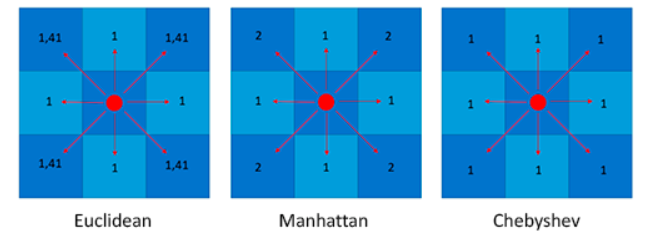  

**Косинусное расстояние**  
Косинусное расстояние это мера сходства двух ненулевых векторов. Оценивается косинусное расстояние посредством косинуса угла между двумя векторами.  

Для расчета косинусного расстояния в трехмерном пространстве используется следующая формула:  
$$\large
D_{cos} = 1 - \frac{x_1 x_2 + y_1 y_2 + z_1 z_2}{\sqrt{x_1^2 + y_1^2 + z_1^2} * \sqrt{x_2^2 + y_2^2 + z_2^2}}
$$

### Реализация  
Добавьте в класс MyKNNClf параметр metric, который принимает одно из следующих значений:  

* euclidean  
* chebyshev  
* manhattan  
* cosine  

Значение по-умолчанию: euclidean  

При обучении и вычислении дистанции между точками должна использоваться соответствующая метрика.

In [15]:
class MyKNNClf():
    
    def __init__(self,
                 k: int = 3,
                 metric: str = 'euclidean'):
    
        self.k = k
        self.metric = metric # euclidean, chebyshev, manhattan, cosine
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNClf class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    # Обучение
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)
    
    # Рассчет Евклидова расстояния
    def _euclidean(self, X_i: np.array) -> np.array:
        return np.sqrt(np.sum((self.X_train - X_i) ** 2, axis=1))
    
    # Рассчет Манхэттенского расстояния
    def _manhattan(self, X_i: np.array) -> np.array:
        return np.sum(np.abs(self.X_train - X_i), axis=1)
    
    # Рассчет расстояния Чебышева
    def _chebyshev(self, X_i: np.array) -> np.array:
        return np.max(np.abs(self.X_train - X_i), axis = 1)
    
    # Рассчет косинусного расстояния
    def _cosine(self, X_i: np.array) -> np.array:
        return 1 - np.sum(self.X_train * X_i, axis = 1) / np.sqrt(np.sum(X_i**2) *  np.sum(self.X_train**2, axis = 1))
    
    # Предсказание класса для одного наблюдения 
    def _make_prediction(self, X_i: np.array) -> int:
        distances = getattr(self, '_' + self.metric)(X_i)
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_classes = y[k_nearest_indexes]
    
        if k_nearest_classes.mean() >= 0.5:
            prediction = 1
        else:
            prediction = 0
       
        return prediction
    
    # Предсказание для ряда наблюдений
    def predict(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction(x) for x in X])
    
    # Предсказание вероятности соотнесения одного наблюдения к классу 1
    def _make_prediction_proba(self, X_i: np.array) -> float:
        distances = getattr(self, '_' + self.metric)(X_i)
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_classes = y[k_nearest_indexes]
        return k_nearest_classes.mean()

    # Предсказание вероятности соотнесения наблюдений к классу 1
    def predict_proba(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction_proba(x) for x in X])


In [16]:
knn = MyKNNClf(3, 'cosine')
knn.fit(X, y)

In [17]:
knn.predict(X).sum()

26

In [18]:
knn.predict_proba(X)

array([1.        , 1.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.66666667, 0.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33333333,
       1.        , 1.        , 1.        , 0.        , 1.        ,
       0.66666667, 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       1.        , 0.66666667, 0.        , 1.        , 0.        ,
       0.        , 0.        , 1.        , 0.66666667, 0.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ])

In [19]:
knn.predict_proba(X).sum()

25.0

### 3.1.5 Взвешенный kNN<a id ='3.1.5'></a>

У базового алгоритма kNN есть один большой недостаток: он никак не учитывает расстояния между объектами при определении класса. Однако, логично предположить, что чем дальше пример расположен от классифицируемого объекта в пространстве признаков, тем ниже его значимость для определения класса.  

Так появился метод взвешенных ближайших соседей (взвешенный kNN), в котором при расчете класса целевого объекта учитываются веса соседей.  

Есть множество вариантов подбора весов для объектов. В этом курсе мы рассмотрим два:  

**Порядковый номер**  
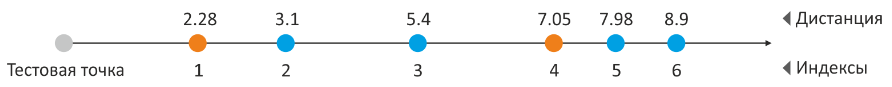  
В этом варианте соседу приписывается вес обратно пропорциональный порядковому номеру соседа в отсортированном по удаленности списке.  

Тогда вес каждого класса это сумма весов соседей из класса нормированная на сумму весов всех соседей:  
$$\large
Q_j = \frac{\sum_{i=1}^{n_j}{\frac{1}{R_{ij}}}}{\sum_{i=1}^n{\frac{1}{R_i}}}
$$  

где:  
* Q_j - вес j-го класса;  
* R_ij - порядковый номер i-го соседа j-го класса;
* R_i - порядковый номер i-го соседа.  
З.Ы. Отсчет порядковых номеров начинается с 1.  

В результате объекту приписывается класс, который набирает наибольший суммарный вес среди k ближайших соседей.  

**Дистанция**  

Здесь вес соседа зависит напрямую от расстояния до него. Чем меньше расстояние, тем более значимый вклад вносит голос.
А вес каждого класса определяется следующим образом:  
$$\large
Q_j = \frac{\sum_{i=1}^{n_j}{\frac{1}{D_{ij}}}}{\sum_{i=1}^n{\frac{1}{D_i}}}
$$  

где:  
* D_ij - дистанция до i-го соседа j-го класса;
* D_i - дистанция до i-го соседа.  

Как и в предыдущем варианте, побеждает класс набравший наибольший вес.  

**Пример**  
Возьмем гипотетическую точку, рядом с которой находятся следующие пять точек уже отсортированных по расстоянию:  
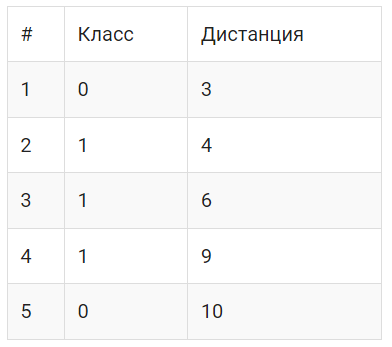  
Посчитаем вес классов по их рангу:  
$$\large
Q_0 = \frac{\frac{1}{1} + \frac{1}{5}}{\frac{1}{1} + \frac{1}{2} + \frac{1}{3} + \frac{1}{4} + \frac{1}{5}} = 0,525547
$$  
$$\large
Q_0 = \frac{\frac{1}{2} + \frac{1}{3} + \frac{1}{4}}{\frac{1}{1} + \frac{1}{2} + \frac{1}{3} + \frac{1}{4} + \frac{1}{5}} = 0,474453
$$

В это случае мы бы присвоили искомой точке 0 класс  

Посчитаем вес классов по их удаленности:  

$$\large
Q_0 = \frac{\frac{1}{3} + \frac{1}{10}}{\frac{1}{3} + \frac{1}{4} + \frac{1}{6} + \frac{1}{9} + \frac{1}{10}} = 0,450867
$$  
$$\large
Q_0 = \frac{\frac{1}{4} + \frac{1}{6} + \frac{1}{9}}{\frac{1}{3} + \frac{1}{4} + \frac{1}{6} + \frac{1}{9} + \frac{1}{10}} = 0,549133
$$

А в этом случае мы бы уже присвоили 1 класс.

### Реализация

Добавьте в класс MyKNNClf параметр weight, которые принимает одно из следующих значений:  

* uniform  
* rank  
* distance  
Значение по-умолчанию: uniform

Внесите следуюшие изменения в работу алгоритма:  
1. Если weight = uniform работаем как и раньше.  
2. Если weight = rank или distance, то:  
    1. Метод predict должен вычислять и возвращать класс с наибольшим весом. 
    2. Метод predict_proba должен возвращать вес класса 1.  

In [20]:
class MyKNNClf():
    
    def __init__(self,
                 k: int = 3,
                 metric: str = 'euclidean',
                 weight: str = 'uniform'):
    
        self.k = k
        self.metric = metric # euclidean, chebyshev, manhattan, cosine 
        self.weight = weight # uniform, rank, distance
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNClf class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    # Обучение
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)
    
    # Рассчет Евклидова расстояния
    def _euclidean(self, X_i: np.array) -> np.array:
        return np.sqrt(np.sum((self.X_train - X_i) ** 2, axis=1))
    
    # Рассчет Манхэттенского расстояния
    def _manhattan(self, X_i: np.array) -> np.array:
        return np.sum(np.abs(self.X_train - X_i), axis=1)
    
    # Рассчет расстояния Чебышева
    def _chebyshev(self, X_i: np.array) -> np.array:
        return np.max(np.abs(self.X_train - X_i), axis = 1)
    
    # Рассчет косинусного расстояния
    def _cosine(self, X_i: np.array) -> np.array:
        return 1 - np.sum(self.X_train * X_i, axis = 1) / np.sqrt(np.sum(X_i**2) *  np.sum(self.X_train**2, axis = 1))
    
    # Предсказание класса всех наблюдений
    def predict(self, X: pd.DataFrame) -> np.array:
        return np.where(self.predict_proba(X) >= 0.5, 1, 0)
    
    # Предсказание вероятности соотнесения одного наблюдения к классу 1
    def _make_prediction_proba(self, X_i: np.array) -> float:
        distances = getattr(self, '_' + self.metric)(X_i)
        k_nearest_distances = np.sort(distances)[:self.k]
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_classes = y[k_nearest_indexes].ravel()
        
        df = pd.DataFrame({'ranks': np.arange(1, self.k+1), 
                           'classes': k_nearest_classes, 
                           'distances': k_nearest_distances})
        
        # Взвешенный kNN
        # веса соседей не учитываются
        if self.weight == 'uniform':
            return k_nearest_classes.mean()
        # по порядковому номеру
        elif self.weight == 'rank':
            Q_1 = (1 / df[df.classes == 1].ranks).sum() / (1 / df.ranks).sum()
            return Q_1
        # по дистанции    
        elif self.weight == 'distance':
            D_1 = (1 / df[df.classes == 1].distances).sum() / (1 / df.distances).sum()
            return D_1   
        else:
            raise ValueError('Invalid weight. Supported weights: uniform, rank, distance')

    # Предсказание вероятности соотнесения всех наблюдений к классу 1
    def predict_proba(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction_proba(x) for x in X])

In [21]:
knn = MyKNNClf(3, 'cosine', 'rank')
knn.fit(X, y)

In [22]:
knn.predict(X).sum()

25

In [23]:
knn.predict_proba(X).sum()

25.0

## 3.2 Метод ближайших соседей (регрессия)<a id='3.2'></a>

In [24]:
import pandas as pd
import numpy as np

In [25]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=50, n_features=5, n_informative=2, noise=5, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)
X.columns = [f'col_{col}' for col in X.columns]

kNN для регрессии это по сути упрощенная версия kNN для классификации. Тут нам не нужно подсчитывать классы. Мы просто берем и усредняем таргет k ближайших соседей.  
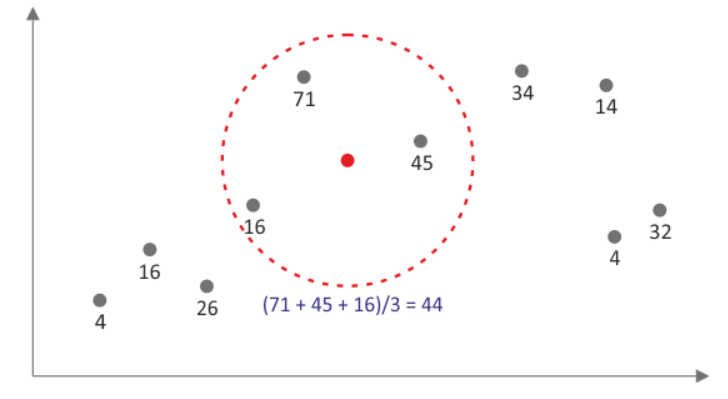

### 3.2.1 Инициализация класса<a id='3.2.1'></a>

Создайте класс с именем MyKNNReg. Данный класс при инициализации должен принимать один параметр:  

k – кол-во ближайших соседей, которые будем рассматривать при подсчете ответа. По-умолчанию: 3.  
Все переданные (или дефолтные) параметры должны быть сохранены внутри класса.  

При обращении к экземпляру класса (или при передачи его в функцию print) необходимо распечатать строку по следующему шаблону:  
```python
MyKNNReg class: k=<k>
```

In [26]:
class MyKNNReg():
    
    def __init__(self,
                 k: int = 3):
    
        self.k = k
        
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNReg class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()

In [27]:
knnreg = MyKNNReg()
knnreg

MyKNNReg class: k=3

### 3.2.2 Обучение<a id='3.2.2'></a>

Доработайте класс MyKNNReg следующим образом:  

1. В инициализатор класса добавьте переменную train_size. В ней будет храниться размер обучающей выборки.  
2. Добавьте в класс метод fit. Данный метод должен делать следующее:   
    1. На вход принимать две переменные:  
        - X — все фичи в виде датафрейма пандаса.  
        - y — целевая переменная в виде пандасовской серии.  
    2. Сохранять X и y внутри модели.  
    3. Записать в переменную train_size размер тренировочной выборки (X) в виде кортежа: (количество_строк, количество_столбцов)

In [28]:
class MyKNNReg():
    
    def __init__(self,
                 k: int = 3):
    
        self.k = k
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
        
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNReg class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)

In [29]:
knnreg = MyKNNReg()
knnreg.fit(X, y)
knnreg.train_size

(50, 5)

### 3.2.3 Предсказание<a id='3.2.3'></a>

Добавьте в класс MyKNNReg метод predict, который должен делать следующее:  

1. На вход принимать матрицу фичей в виде датафрейма пандаса.  
2. Для каждого объекта тестовой выборки последовательно выполнить следующие шаги:  
    1. Вычислить расстояние до каждого объекта из обучающей выборки. Сейчас расстояние будем вычислять по формуле Евклида.
       $$D_{eucl} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}$$  
        где:  
        * x1, y1, z1 – координаты (или иные количественные свойства) первой точки;  
        * x2, y2, z2 – координаты второй точки.
        
    2. Отобрать k объектов обучающей выборки, расстояние до которых минимально.  
    3. Усреднить значения таргета ближайших k объектов.
3. Вернуть вектор предсказаний.  

In [30]:
class MyKNNReg():
    
    def __init__(self,
                 k: int = 3):
    
        self.k = k
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
        
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNReg class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    # Обучение
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)
        
    # Рассчет предсказанного значения для одного наблюдения
    def _make_prediction(self, X_i: np.array) -> float:
        distances = np.sqrt(np.sum((self.X_train - X_i) ** 2, axis=1))
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_targets = y[k_nearest_indexes].ravel()
        
        return k_nearest_targets.mean()
    
    # Получить вектор предсказаний
    def predict(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction(x) for x in X])

In [31]:
knnreg = MyKNNReg()
knnreg.fit(X, y)

In [32]:
knnreg.predict(X)

array([  8.64807018,  42.35755401,  -1.73189778,  -7.80942957,
        76.52610343, -69.45890145,  52.39652796,  53.66548119,
        72.45531191,  16.1750417 ,  59.68553848, -62.76368774,
       -20.61752922,  44.80078851,  64.02685696,  23.10223906,
        15.71243244, -92.41145939, -98.33957354,  63.52963809,
        -7.50772697,  51.91195764, -49.18673981,   6.23726661,
        42.35755401,   9.81377082,  61.56762337, -25.53058192,
        51.91195764, -92.41145939,  35.02027971,  -1.52822233,
        -8.97300158,  23.96164893,  -4.12152998,  15.98568871,
       -69.45890145,  17.42887829,  21.34165415,  62.38771606,
       -76.72843174, -28.00759259,  15.71243244,  -4.83796037,
         6.83977407,  -7.80942957,  -5.03945639, -92.41145939,
        -7.50772697,  51.91195764])

In [33]:
knnreg.predict(X).sum()

233.27904484892773

### 3.2.4 Метрики<a id='3.2.4'></a>

Добавьте в класс MyKNNClf параметр metric, который принимает одно из следующих значений:  

* euclidean  
* chebyshev  
* manhattan  
* cosine  

Значение по-умолчанию: euclidean  

* Евклидово расстояние:  $$D_{eucl} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2 + (z_2 - z_1)^2}$$  
* Расстояние Чебышёва:  $$D_{cheb} = max(|x_2 - x_1|, |y_2 - y_1|, |z_2 - z_1|)$$  
* Манхэттенское расстояние:  $$D_{manh} = |x_2 - x_1| + |y_2 - y_1| + |z_2 - z_1|$$  
* Косинусное расстояние:  $$D_{cos} = 1 - \frac{x_1 x_2 + y_1 y_2 + z_1 z_2}{\sqrt{x_1^2 + y_1^2 + z_1^2} * \sqrt{x_2^2 + y_2^2 + z_2^2}}$$


In [34]:
class MyKNNReg():
    
    def __init__(self,
                 k: int = 3,
                 metric: str = 'euclidean'):
    
        self.k = k
        self.metric = metric # euclidean, chebyshev, manhattan, cosine 
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
        
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNReg class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    # Обучение
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)  
        
    # Рассчет Евклидова расстояния
    def _euclidean(self, X_i: np.array) -> np.array:
        return np.sqrt(np.sum((self.X_train - X_i) ** 2, axis=1))
    
    # Рассчет Манхэттенского расстояния
    def _manhattan(self, X_i: np.array) -> np.array:
        return np.sum(np.abs(self.X_train - X_i), axis=1)
    
    # Рассчет расстояния Чебышева
    def _chebyshev(self, X_i: np.array) -> np.array:
        return np.max(np.abs(self.X_train - X_i), axis = 1)
    
    # Рассчет косинусного расстояния
    def _cosine(self, X_i: np.array) -> np.array:
        return 1 - np.sum(self.X_train * X_i, axis = 1) / np.sqrt(np.sum(X_i**2) *  np.sum(self.X_train**2, axis = 1))
        
    # Рассчет предсказанного значения для одного наблюдения
    def _make_prediction(self, X_i: np.array) -> float:
        distances = getattr(self, '_' + self.metric)(X_i)
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_targets = y[k_nearest_indexes].ravel()
        
        return k_nearest_targets.mean()
    
    # Получить вектор предсказаний
    def predict(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction(x) for x in X])

In [35]:
knnreg = MyKNNReg(3, 'cosine')
knnreg.fit(X, y)

In [36]:
knnreg.predict(X).sum()

442.00164022314783

### 3.2.5 Взвешенный kNN<a id='3.2.5'></a>

В регрессии, чтобы подсчитать таргет для тестовой точки нам нужно сложить таргеты ее k ближайших соседей, умноженных на их веса.  
$$\large
\hat y = \sum_{i=1}^n{w_iy_i}
$$  
где:  
* y^ - предсказания для тестовой точки;   
* w_i - вес i-го соседа;  
* y_i - таргет i-го соседа.  

А вес для соседа вычисляется в зависимости от подхода:  

**Для порядковых номеров**  
$$\large
w_i = \frac{\frac{1}{R_i}}{\sum_{j=1}^n{\frac{1}{R_j}}}
$$  

где:  
* R_i - порядковый номер i-го соседа;  
* R_j - порядковый номер среди всех ближайших соседей.  
*порядковые номера начинаются с 1.*  

**Для дистанции**  
$$\large
w_i = \frac{\frac{1}{D_i}}{\sum_{j=1}^n{\frac{1}{D_j}}}
$$ 
где:  
* D_i - дистанция до i-го соседа;  
* D_j - дистанция среди всех ближайших соседей.  

### Реализация

Добавьте в класс MyKNNReg параметр weight, которые принимает одно из следующих значений:  

* uniform  
* rank  
* distance  
Значение по-умолчанию: uniform  

Внесите следуюшие изменения в работу алгоритма:  
1. Если weight = uniform работаем как и раньше.  
2. Если weight = rank или distance, то метод predict должен вычислять предсказания с учетом весов соседей.  

In [37]:
class MyKNNReg():
    
    def __init__(self,
                 k: int = 3,
                 metric: str = 'euclidean',
                 weight: str = 'uniform'):
    
        self.k = k
        self.metric = metric # euclidean, chebyshev, manhattan, cosine 
        self.weight = weight # uniform, rank, distance
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
        
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNReg class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    # Обучение
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)  
        
    # Рассчет Евклидова расстояния
    def _euclidean(self, X_i: np.array) -> np.array:
        return np.sqrt(np.sum((self.X_train - X_i) ** 2, axis=1))
    
    # Рассчет Манхэттенского расстояния
    def _manhattan(self, X_i: np.array) -> np.array:
        return np.sum(np.abs(self.X_train - X_i), axis=1)
    
    # Рассчет расстояния Чебышева
    def _chebyshev(self, X_i: np.array) -> np.array:
        return np.max(np.abs(self.X_train - X_i), axis = 1)
    
    # Рассчет косинусного расстояния
    def _cosine(self, X_i: np.array) -> np.array:
        return 1 - np.sum(self.X_train * X_i, axis = 1) / np.sqrt(np.sum(X_i**2) *  np.sum(self.X_train**2, axis = 1))
        
    # Рассчет предсказанного значения для одного наблюдения
    def _make_prediction(self, X_i: np.array) -> float:
        distances = getattr(self, '_' + self.metric)(X_i)
        k_nearest_distances = np.sort(distances)[:self.k]
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_targets = y[k_nearest_indexes].ravel()
        
        df = pd.DataFrame({'ranks': np.arange(1, self.k+1), 
                           'targets': k_nearest_targets, 
                           'distances': k_nearest_distances})
        
        # Взвешенный kNN
        # веса соседей не учитываются
        if self.weight == 'uniform':
            return k_nearest_targets.mean()
        # по порядковому номеру
        elif self.weight == 'rank':
            df['weights'] = (1 / df.ranks) / (1 / df.ranks).sum()
            return (df.weights * df.targets).sum()
        # по дистанции    
        elif self.weight == 'distance':
            df['weights'] = (1 / df.distances) / (1 / df.distances).sum()
            return (df.weights * df.targets).sum()    
        else:
            raise ValueError('Invalid weight. Supported weights: uniform, rank, distance')
    
    # Получить вектор предсказаний
    def predict(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction(x) for x in X])

In [38]:
knnreg = MyKNNReg(3, 'cosine', 'rank')
knnreg.fit(X, y)

In [39]:
knnreg.predict(X).sum()

409.73802893550874

### Финальные версии моделей<a id='3fin'></a>

**Классификация**

In [40]:
class MyKNNClf():
    
    def __init__(self,
                 k: int = 3,
                 metric: str = 'euclidean',
                 weight: str = 'uniform'):
    
        self.k = k
        self.metric = metric # euclidean, chebyshev, manhattan, cosine 
        self.weight = weight # uniform, rank, distance
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNClf class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    # Обучение
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)
    
    # Рассчет Евклидова расстояния
    def _euclidean(self, X_i: np.array) -> np.array:
        return np.sqrt(np.sum((self.X_train - X_i) ** 2, axis=1))
    
    # Рассчет Манхэттенского расстояния
    def _manhattan(self, X_i: np.array) -> np.array:
        return np.sum(np.abs(self.X_train - X_i), axis=1)
    
    # Рассчет расстояния Чебышева
    def _chebyshev(self, X_i: np.array) -> np.array:
        return np.max(np.abs(self.X_train - X_i), axis = 1)
    
    # Рассчет косинусного расстояния
    def _cosine(self, X_i: np.array) -> np.array:
        return 1 - np.sum(self.X_train * X_i, axis = 1) / np.sqrt(np.sum(X_i**2) *  np.sum(self.X_train**2, axis = 1))
    
    # Предсказание класса всех наблюдений
    def predict(self, X: pd.DataFrame) -> np.array:
        return np.where(self.predict_proba(X) >= 0.5, 1, 0)
    
    # Предсказание вероятности соотнесения одного наблюдения к классу 1
    def _make_prediction_proba(self, X_i: np.array) -> float:
        distances = getattr(self, '_' + self.metric)(X_i)
        k_nearest_distances = np.sort(distances)[:self.k]
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_classes = y[k_nearest_indexes].ravel()
        
        df = pd.DataFrame({'ranks': np.arange(1, self.k+1), 
                           'classes': k_nearest_classes, 
                           'distances': k_nearest_distances})
        
        # Взвешенный kNN
        # веса соседей не учитываются
        if self.weight == 'uniform':
            return k_nearest_classes.mean()
        # по порядковому номеру
        elif self.weight == 'rank':
            Q_1 = (1 / df[df.classes == 1].ranks).sum() / (1 / df.ranks).sum()
            return Q_1
        # по дистанции    
        elif self.weight == 'distance':
            D_1 = (1 / df[df.classes == 1].distances).sum() / (1 / df.distances).sum()
            return D_1   
        else:
            raise ValueError('Invalid weight. Supported weights: uniform, rank, distance')

    # Предсказание вероятности соотнесения всех наблюдений к классу 1
    def predict_proba(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction_proba(x) for x in X])

**Регрессия**

In [ ]:
class MyKNNReg():
    
    def __init__(self,
                 k: int = 3,
                 metric: str = 'euclidean',
                 weight: str = 'uniform'):
    
        self.k = k
        self.metric = metric # euclidean, chebyshev, manhattan, cosine 
        self.weight = weight # uniform, rank, distance
        
        self.X_train = None
        self.y_train = None
        self.train_size = None
        
    
    def __repr__(self):
        params = [f'{key}={value}' for key, value in self.__dict__.items()]
        return 'MyKNNReg class: ' + ', '.join(params)
        
    def __str__(self):
        return self.__repr__()
    
    # Обучение
    def fit(self, X:pd.DataFrame, y:pd.Series) -> None:
        self.X_train = X.copy()
        self.y_train = y.copy()
        self.train_size = tuple(X.shape)  
        
    # Рассчет Евклидова расстояния
    def _euclidean(self, X_i: np.array) -> np.array:
        return np.sqrt(np.sum((self.X_train - X_i) ** 2, axis=1))
    
    # Рассчет Манхэттенского расстояния
    def _manhattan(self, X_i: np.array) -> np.array:
        return np.sum(np.abs(self.X_train - X_i), axis=1)
    
    # Рассчет расстояния Чебышева
    def _chebyshev(self, X_i: np.array) -> np.array:
        return np.max(np.abs(self.X_train - X_i), axis = 1)
    
    # Рассчет косинусного расстояния
    def _cosine(self, X_i: np.array) -> np.array:
        return 1 - np.sum(self.X_train * X_i, axis = 1) / np.sqrt(np.sum(X_i**2) *  np.sum(self.X_train**2, axis = 1))
        
    # Рассчет предсказанного значения для одного наблюдения
    def _make_prediction(self, X_i: np.array) -> float:
        distances = getattr(self, '_' + self.metric)(X_i)
        k_nearest_distances = np.sort(distances)[:self.k]
        k_nearest_indexes = np.argsort(distances)[:self.k]
        k_nearest_targets = y[k_nearest_indexes].ravel()
        
        df = pd.DataFrame({'ranks': np.arange(1, self.k+1), 
                           'targets': k_nearest_targets, 
                           'distances': k_nearest_distances})
        
        # Взвешенный kNN
        # веса соседей не учитываются
        if self.weight == 'uniform':
            return k_nearest_targets.mean()
        # по порядковому номеру
        elif self.weight == 'rank':
            df['weights'] = (1 / df.ranks) / (1 / df.ranks).sum()
            return (df.weights * df.targets).sum()
        # по дистанции    
        elif self.weight == 'distance':
            df['weights'] = (1 / df.distances) / (1 / df.distances).sum()
            return (df.weights * df.targets).sum()    
        else:
            raise ValueError('Invalid weight. Supported weights: uniform, rank, distance')
    
    # Получить вектор предсказаний
    def predict(self, X: pd.DataFrame) -> np.array:
        X = X.to_numpy()
        return np.array([self._make_prediction(x) for x in X])